# VIP This notebook use data from `Fig2.ipynb`

In [1]:
import os, sys, warnings

import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context(context='poster')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.monospace'] = 'Andale Mono'
# mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.default'] = 'rm'

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{wasysym}',
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}',
]

bigsize   = 20
midsize   = 18
smallsize = 14
hugesize  = 24

In [2]:
sys.path.append('.'); warnings.simplefilter(action='ignore', category=FutureWarning);

In [ ]:
from figdata import ref, xlsx_tab, sum_df, cell_chr_cnv_size
from figdata import sample_colors, good_pos, r_acen, chrf, bigCNV, big_cnv_cells, big_cnv_idx

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.linear_model import LinearRegression

In [4]:
from scipy import stats

In [5]:
FSAMPLE = True
FSAMPLE = False

---

In [6]:
male_heatmap   = pd.read_csv('male_heatmap.csv',   index_col=0)
female_heatmap = pd.read_csv('female_heatmap.csv', index_col=0)

cmap_CNV = LinearSegmentedColormap.from_list('forCNV', ['blueviolet', 'deepskyblue', 'black', 'darkorange', 'orangered'])

# # Sort fraction
tmp_df = sum_df.loc[big_cnv_idx].sort_values('chrom_fraction', ascending=False)
tmp_df['chrom_fraction'] = (tmp_df['chrom_fraction']/10).round()
# # Sort chroms.
heatmap_order = (
    tmp_df.set_index('Cell')
    .loc[tmp_df['Cell']]
    .reset_index()
    .groupby('Cell',sort=False).first()
    .replace({'Sample':xlsx_tab.set_index('SAMPLE')['CODE'].to_dict()})
#     .sort_values(['chr_id','chrom_fraction','cnvTag','binSize','Cell'], ascending=[True, False, True, False, True])
    .sort_values(
        ['chr_id','chrom_fraction','cnvTag','Sample','binSize','Cell'], 
        ascending=[True, False, True, True, False, True]
    )
    .index
)

# # Sort fraction
# tmp_df = cell_chr_cnv_size.sort_values('chrom_fraction', ascending=False)
# # Sort chroms.
# heatmap_order = (
#     tmp_df.reset_index().set_index('Cell')
#     .loc[tmp_df['Cell']]
#     .reset_index()
#     .groupby('Cell',sort=False).first()
#     .sort_values(['chr_id','chrom_fraction','binSize','Cell'], ascending=[True, False, False, True])
#     .index
# )

del(tmp_df)

In [7]:
male_fig_df = male_heatmap.reindex(columns=big_cnv_cells).dropna(how='all',axis=1).T
male_fig_df.loc[:,male_fig_df.columns[male_fig_df.columns.str.contains(r'chr[X|Y]:')]] += 1
male_fig_df = male_fig_df.loc[:, ~male_fig_df.columns.str.contains('chrY')]

chr_pos = [ 
    male_fig_df.columns.get_loc(idx) 
    for idx in ref.loc[male_fig_df.columns]
        .reset_index()
        .set_index(['space','start'])
        .loc[
            ref.loc[male_fig_df.columns]
            .groupby('space',sort=False)
            .min().reset_index()
            .set_index(['space','start']).index,
            'index'
        ].values 
] + [ male_fig_df.columns.get_loc( male_fig_df.columns[-1] )-1 ]


if not FSAMPLE:
    male_fig_df = male_fig_df.loc[male_fig_df.index[~male_fig_df.index.str.contains('$FSAMPLE')]]

In [8]:
male_row_codes = xlsx_tab.set_index('SAMPLE').loc[
    (
        sum_df
        .set_index('Cell')
        .loc[male_fig_df.index,'Sample']
        .reset_index()
        .drop_duplicates(keep='first')
        .set_index('Cell')
        .reindex(index=heatmap_order)
        .dropna()['Sample']
    ), 'CODE'
].dropna()

male_row_codes.index = (np.arange(0,male_row_codes.shape[0]))

if not FSAMPLE:
    male_row_codes = male_row_codes.replace('M11','M10')

male_sample_fig_df = pd.concat(
    [
        pd.Series(np.arange(0,male_row_codes.shape[0]), name='y'),
        male_row_codes.rename('x').str.replace('M','').astype(int),
    ], axis=1
)

In [9]:
female_fig_df = female_heatmap.reindex(columns=big_cnv_cells).dropna(how='all',axis=1).T
female_fig_df.loc[:,female_fig_df.columns[female_fig_df.columns.str.contains(r'chrY:')]] += 2
female_fig_df = female_fig_df.loc[:, ~female_fig_df.columns.str.contains('chrY')]

female_row_codes = xlsx_tab.set_index('SAMPLE').loc[
    (
        sum_df
        .set_index('Cell')
        .loc[female_fig_df.index,'Sample']
        .reset_index()
        .drop_duplicates(keep='first')
        .set_index('Cell')
        .reindex(index=heatmap_order)
        .dropna()['Sample']
    ), 'CODE'
].dropna()

female_row_codes.index = (np.arange(0,female_row_codes.shape[0]))

female_sample_fig_df = pd.concat(
    [
        pd.Series(np.arange(0,female_row_codes.shape[0]), name='y'),
        female_row_codes.rename('x').str.replace('F','').astype(int),
    ], axis=1
)

---

In [10]:
def male_heatmap_plot(ax1, ax2):
#     ax1.scatter(
#         male_sample_fig_df['x'], male_sample_fig_df['y'],
#         s = 3, marker = 's',
#         color = pd.Series(sample_colors)[male_sample_fig_df['x']-1],
#     )
    ax1.hlines(
        male_sample_fig_df['y'],
        male_sample_fig_df['x']-0.3, male_sample_fig_df['x']+0.3,
        color = pd.Series(sample_colors)[male_sample_fig_df['x']-1],
        lw=1
    )

    sns.heatmap(
        male_fig_df.reindex(index=heatmap_order).dropna(),
        cmap    = cmap_CNV,
        ax      = ax2,
        cbar    = None,
        vmax=4, vmin=0, center=2,
        xticklabels=[], yticklabels=[],
        rasterized=True,
    )

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylabel('Male Cell (n = ' + str(male_fig_df.shape[0]) + ')' , fontsize=midsize)
    ax1.set_xlim(0,male_sample_fig_df['x'].max()+1)

    ax2.vlines(chr_pos, ax2.get_ylim()[0], ax2.get_ylim()[1], lw=1, color='lightgrey')
    ax2.set_ylabel('')
    ax2.set_xticks([])
    ax2.set_yticks([])

    return

In [11]:
def female_heatmap_plot(ax1, ax2, ax3):
#     ax1.scatter(
#         female_sample_fig_df['x'], female_sample_fig_df['y'], 
#         s = 3, marker = 's',
#         color = pd.Series(sample_colors[11:])[female_sample_fig_df['x']-1],
#     )
    ax1.hlines(
        female_sample_fig_df['y'], 
        female_sample_fig_df['x']-0.3, female_sample_fig_df['x']+0.3,
        color = pd.Series(sample_colors[11:])[female_sample_fig_df['x']-1],
        lw=1
    )

    sns.heatmap(
        female_fig_df.reindex(index=heatmap_order).dropna(),
        cmap    = cmap_CNV,
        ax      = ax2,
        cbar_ax = ax3,
        cbar_kws={
            'ticks'      : np.arange(0,5),
            'boundaries' : np.arange(-0.5,5.5,1),
            'pad'        : 0.01,
            'orientation': 'horizontal',
        },
        vmax=4, vmin=0, center=2, 
        xticklabels=[], yticklabels=[],
        rasterized=True,
    )

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylabel('Female Cell (n = ' + str(female_fig_df.shape[0]) + ')' , fontsize=midsize)
    ax1.set_xlim(0,female_sample_fig_df['x'].max()+1)
    
    ax2.vlines(chr_pos, ax2.get_ylim()[0], ax2.get_ylim()[1], lw=1, color='lightgrey')
    ax2.set_ylabel('')
    ax2.set_xticks([])
    ax2.set_yticks([])

    return

In [12]:
def sample_code_plot(ax, FSAMPLE=True):

#     fig, ax = plt.subplots(figsize=(6,2))

    if not FSAMPLE:
        male_code = xlsx_tab.query('GENDER=="male" & SAMPLE!="$FSAMPLE"')['CODE'].replace('M11','M10')
    else:
        male_code = xlsx_tab.query('GENDER=="male"')['CODE']
        
    female_code = xlsx_tab.query('GENDER=="female"')['CODE']

    ax.scatter(
        x = np.arange(male_code.shape[0]).reshape(1, male_code.shape[0]),
        y = [1]*male_code.shape[0],
        s = 200, marker = 's',
        c=list(pd.Series(sample_colors[:male_code.shape[0]])[ np.arange(male_code.shape[0]) ]),
#         rasterized=True,
    )

    if FSAMPLE:
        shf = 0
    else:
        shf = 1
        
    dif = male_code.shape[0]-female_code.shape[0]
    
    ax.scatter(
        x = np.arange(female_code.shape[0]).reshape(1, female_code.shape[0])+dif,
        y = [0]*female_code.shape[0],
        s = 200, marker = 's',
        c=list(pd.Series(sample_colors[male_code.shape[0]+shf:])[ np.arange(female_code.shape[0]) ]),
#         rasterized=True,
    )

    for n,t in enumerate(male_code):
        ax.text(n,      0.5, t.replace('M',''), fontsize=smallsize, ha='center', va='center' )

    for n,t in enumerate(female_code):
        ax.text(n+dif, -0.5, t.replace('F',''), fontsize=smallsize, ha='center', va='center' )

    ax.text(-1,     1, 'M', fontsize=smallsize, ha='center', va='center' )
    ax.text(-1+dif, 0, 'F', fontsize=smallsize, ha='center', va='center' )
    ax.set_ylabel('Sample\nColor Code', fontsize=smallsize, rotation=0, ha='center', va='center', labelpad=2*hugesize)

    ax.set_xlim(-0.5,11.5)
    ax.set_ylim(-0.5,1.5)

    ax.set_xticks([])
    ax.set_yticks([])
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_visible(False)

    return 

---

In [13]:
from figdata import ref, xlsx_tab, cells_tab, mmqc, good_df, sum_df, cell_chr_cnv_size, big_cnv_idx
from figdata import sample_colors, good_pos, chrf, bigCNV

from pybedtools import BedTool as BedTools
from pybedtools import cleanup as tmpCleanUp

In [14]:
def male_genome_plot(ax, FSAMPLE=True):
    # fig, ax = plt.subplots(figsize=(20,4))

    n = pd.concat(
        [
            cells_tab, 
            xlsx_tab.set_index('SAMPLE')
        ], axis=1, sort=False
    ).query('GENDER=="male"')

    big_cnv_gain =(
        sum_df
        .loc[big_cnv_idx]
        .query('cnvTag=="Gain" & Gender=="male"')
    )

    big_cnv_loss =(
        sum_df
        .loc[big_cnv_idx]
        .query('cnvTag=="Loss" & Gender=="male"')
    )
    
    if not FSAMPLE:
        big_cnv_gain = big_cnv_gain.query('Sample!="$FSAMPLE"')
        big_cnv_loss = big_cnv_loss.query('Sample!="$FSAMPLE"')
        n = n.drop('$FSAMPLE')['n_pf'].sum()
    else:
        n = n['n_pf'].sum()
    

    bin_bed  = BedTools.from_dataframe(ref.loc[good_df.index])
    gain_bed = BedTools.from_dataframe(big_cnv_gain)
    loss_bed = BedTools.from_dataframe(big_cnv_loss)

    gain_s = BedTools.intersect(self=bin_bed,b=gain_bed,wa=True,c=True).to_dataframe().set_index(good_df.index)['score']
    loss_s = BedTools.intersect(self=bin_bed,b=loss_bed,wa=True,c=True).to_dataframe().set_index(good_df.index)['score']

    tmpCleanUp()
    
    ax.plot(np.arange(male_fig_df.columns.shape[0]),  100*gain_s[male_fig_df.columns].fillna(0)/n, '-', lw=2, color='darkorange',  label='Gain', zorder=1)
    ax.plot(np.arange(male_fig_df.columns.shape[0]), -100*loss_s[male_fig_df.columns].fillna(0)/n, '-', lw=2, color='deepskyblue', label='Loss', zorder=1)

    # Plot chroms. boundary
    g = ref.groupby('space').min()['abs_pos']

    for pos in chr_pos:
        ax.plot(np.tile(pos,10), np.linspace(-3, 9, 10), '-', color='black', alpha=0.5, lw=1, zorder=0)

    ax.set_ylabel('Freq.\n(%)', fontsize=midsize)
    ax.set_xticks( pd.Series(chr_pos).rolling(2).mean()[1:] )
    ax.set_xticklabels(
        ref['space'].drop_duplicates()[:-1].str.replace('chr','').replace('19','    19').replace('21','    21').replace('X','    X'), 
        fontsize=smallsize-4,
        ha='center',
        rotation=90,
    )
    ax.xaxis.set_ticks_position('top')
    ax.set_ylim(-0.4,0.4)
    ax.set_yticks( [-0.3, 0, 0.3] )
    ax.set_yticklabels( [0.3, 0 ,0.3], fontsize=smallsize )

    ax.tick_params(axis='x', bottom=False, length=0, pad=5)
    ax.tick_params(axis='y', length=5)
    
    return 

In [15]:
def female_genome_plot(ax1, ax2):
# f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,2), gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})

    n = pd.concat(
        [
            cells_tab, 
            xlsx_tab.set_index('SAMPLE')
        ], axis=1, sort=False
    ).query('GENDER=="female"')['n_pf'].sum()

    big_cnv_gain =(
        sum_df
        .loc[big_cnv_idx]
        .query('cnvTag=="Gain" & Gender=="female"')
    )

    big_cnv_loss =(
        sum_df
        .loc[big_cnv_idx]
        .query('cnvTag=="Loss" & Gender=="female"')
    )

    bin_bed  = BedTools.from_dataframe(ref.loc[good_df.index])
    gain_bed = BedTools.from_dataframe(big_cnv_gain)
    loss_bed = BedTools.from_dataframe(big_cnv_loss)

    gain_s = BedTools.intersect(self=bin_bed,b=gain_bed,wa=True,c=True).to_dataframe().set_index(good_df.index)['score']
    loss_s = BedTools.intersect(self=bin_bed,b=loss_bed,wa=True,c=True).to_dataframe().set_index(good_df.index)['score']

    tmpCleanUp()

    ax1.plot(np.arange(female_fig_df.columns.shape[0]),  100*gain_s[female_fig_df.columns].fillna(0)/n, '-', lw=2, color='darkorange',  label='Gain')
    ax2.plot(np.arange(female_fig_df.columns.shape[0]),  100*gain_s[female_fig_df.columns].fillna(0)/n, '-', lw=2, color='darkorange',  label='Gain')
    ax1.plot(np.arange(female_fig_df.columns.shape[0]), -100*loss_s[female_fig_df.columns].fillna(0)/n, '-', lw=2, color='deepskyblue', label='Loss')
    ax2.plot(np.arange(female_fig_df.columns.shape[0]), -100*loss_s[female_fig_df.columns].fillna(0)/n, '-', lw=2, color='deepskyblue', label='Loss')

    # Plot chroms. boundary
    g = ref.groupby('space').min()['abs_pos']

    for pos in chr_pos:
        ax1.plot(np.tile(pos,10), np.linspace(-5, 9, 10), '-', color='black', alpha=0.5, lw=1, zorder=0)
        ax2.plot(np.tile(pos,10), np.linspace(-5, 9, 10), '-', color='black', alpha=0.5, lw=1, zorder=0)

    ax1.set_xticks([])
    ax2.set_xticks([])
    ax1.tick_params(axis='x', bottom=False, length=0)
    ax2.tick_params(axis='x', bottom=False, length=0)
    ax1.tick_params(axis='y', length=5)
    ax2.tick_params(axis='y', length=5)

    ax1.set_ylim(-0.4, 0.4)
    ax2.set_ylim(-4.5, -1.5)

    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)

#     d = 0.01  # how big to make the diagonal lines in axes coordinates
#     kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
#     ax1.plot((-d, +d), (0, 0), **kwargs)        # top-left diagonal
#     ax1.plot((1 - d, 1 + d), (0, 0), **kwargs)  # top-right diagonal

#     kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
#     ax2.plot((-d, +d), (1, 1), **kwargs)  # bottom-left diagonal
#     ax2.plot((1 - d, 1 + d), (1, 1), **kwargs)  # bottom-right diagonal

    ax1.set_ylabel('Freq.\n(%)', fontsize=midsize)

    ax1.set_yticks([0.3,0,-0.3])
    ax1.set_yticklabels(['0.3','0.0','0.3'], fontsize=smallsize)

    ax2.set_yticks([-3])
    ax2.set_yticklabels(['3'], fontsize=smallsize)

    return

---

In [16]:
from A4_ShowCell import showCell

In [17]:
male_cells = [
]

In [18]:
female_cells = [
]

---

In [22]:
size_colors = {
    'Gain':
        [
            '#ff9966',
            '#ff5050',
            '#cc0000',
        ],
    'Loss':
        [
            '#33ccff',
            '#0066ff',
            '#0000cc',
        ]
}

In [23]:
def size_plot(ax1, ax2, ax3, ax4, FSAMPLE=True):
    axs = [ax1, ax2, ax3, ax4]

    # fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(8,5), gridspec_kw={'hspace':0, 'wspace':0.5})
    # axs = axs.T.flatten()

    for n, tag in enumerate(['Gain', 'Loss']):

        fig_df = sum_df.loc[big_cnv_idx].query('Space != "chrY" & cnvTag==@tag')
        if not FSAMPLE:
            fig_df = fig_df.query('Sample!="$FSAMPLE"')
    
        fig_df = fig_df.groupby(['Space','Cell','cnvTag'])['absSize'].sum().reset_index().set_index('cnvTag').loc[tag]

        _,b,_ = axs[n].hist( fig_df['absSize'], bins=50, color='w', label=tag )

        autosome_bin_data = pd.cut(
            x = fig_df.query('Space!="chrX" & Space!="chr21"')['absSize'],
            bins = b,
            labels=b[1:],
            include_lowest=True
        ).astype(int).value_counts()
        chr21_bin_data = pd.cut(
            x = fig_df.query('Space=="chr21"')['absSize'],
            bins = b,
            labels=b[1:],
            include_lowest=True
        ).astype(int).value_counts()
        chrX_bin_data = pd.cut(
            x = fig_df.query('Space=="chrX"')['absSize'],
            bins = b,
            labels=b[1:],
            include_lowest=True
        ).astype(int).value_counts()

        axs[n].bar( 
            autosome_bin_data.index/1e6, 
            autosome_bin_data, 
            width=5, 
            color=size_colors[tag][0],
            edgecolor='k', linewidth=0.75,
        )
        axs[n].bar( 
            chr21_bin_data.index/1e6, 
            chr21_bin_data, 
            width=5, 
            bottom=autosome_bin_data.loc[chr21_bin_data.index].fillna(0), 
            color=size_colors[tag][1],
            edgecolor='k', linewidth=0.75,
        )
        axs[n].bar( 
            chrX_bin_data.index/1e6, 
            chrX_bin_data, 
            width=5, 
            bottom=autosome_bin_data.loc[chrX_bin_data.index].fillna(0) + chr21_bin_data.loc[chrX_bin_data.index].fillna(0), 
            color=size_colors[tag][2],
            edgecolor='k', linewidth=0.75,
        )

        fig_df = sum_df.loc[big_cnv_idx].query('Space != "chrY" & cnvTag==@tag')
        fig_df = fig_df.groupby(['Space','Cell','cnvTag'])['chrom_fraction'].max().reset_index().set_index('cnvTag').loc[tag]

        _,b,_ = axs[2+n].hist( fig_df['chrom_fraction'], bins=50, color='w', label=None )

        autosome_bin_data = pd.cut(
            x = fig_df.query('Space!="chrX" & Space!="chr21"')['chrom_fraction'],
            bins = b,
            labels=b[1:],
            include_lowest=True
        ).astype(int).value_counts()
        chr21_bin_data = pd.cut(
            x = fig_df.query('Space=="chr21"')['chrom_fraction'],
            bins = b,
            labels=b[1:],
            include_lowest=True
        ).astype(int).value_counts()
        chrX_bin_data = pd.cut(
            x = fig_df.query('Space=="chrX"')['chrom_fraction'],
            bins = b,
            labels=b[1:],
            include_lowest=True
        ).astype(int).value_counts()

        axs[2+n].bar( 
            autosome_bin_data.index, 
            autosome_bin_data, 
            width=2, 
            color=size_colors[tag][0],
            edgecolor='k', linewidth=0.75,
            label='Others'
        )
        axs[2+n].bar( 
            chr21_bin_data.index, 
            chr21_bin_data, 
            width=2, 
            bottom=autosome_bin_data.loc[chr21_bin_data.index].fillna(0), 
            color=size_colors[tag][1],
            edgecolor='k', linewidth=0.75,
            label='chr21'
        )
        axs[2+n].bar( 
            chrX_bin_data.index, 
            chrX_bin_data, 
            width=2, 
            bottom=autosome_bin_data.loc[chrX_bin_data.index].fillna(0) + chr21_bin_data.loc[chrX_bin_data.index].fillna(0), 
            color=size_colors[tag][2],
            edgecolor='k', linewidth=0.75,
            label='chrX'
        )

        axs[0+n].set_xlim(0,250)
        axs[2+n].set_xlim(0,104)
        axs[0+n].tick_params(length=5, labelsize=smallsize)
        axs[2+n].tick_params(length=5, labelsize=smallsize)

    axs[0].set_ylim(0,65)
    axs[1].set_ylim(550,0)

    axs[0].set_xticks([])
    axs[1].set_xticks([0,100,200])
    axs[1].set_xlabel('Size (Mb)', fontsize=midsize)

    axs[0].set_ylabel('Gain', fontsize=midsize, labelpad=5)
    axs[1].set_ylabel('Loss', fontsize=midsize, labelpad=-5)

    axs[2].set_ylim(-1,120)
    axs[3].set_ylim(250,1)

    axs[2].set_xticks([])
    axs[3].set_xticks([0,100])
    axs[3].set_xticklabels(['0','1'], fontsize=midsize)
    axs[3].set_xlabel('Fraction', fontsize=midsize)



In [25]:
two_colors = sns.xkcd_palette(['bright blue','red'])

fig_df1 = pd.concat(
    [
        xlsx_tab.set_index('SAMPLE'),
        (
            sum_df.loc[big_cnv_idx]
                .query('Space!="chrX"')
#                 .query('Space!="chr21"')
                .groupby(['Cell','Sample']).count().reset_index()
                .groupby('Sample').count()['Cell']
        ),
        cells_tab['n_pf'],
    ], axis=1, sort=False
)

fig_df1['Ratio'] = 100*fig_df1['Cell']/fig_df1['n_pf']

if not FSAMPLE:
    fig_df1 = fig_df1.drop('$FSAMPLE')

def age_plot(ax1):
#     fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

    ax1.scatter(
        fig_df1.query('GENDER=="male"'  )['AGE'], fig_df1.query('GENDER=="male"'  )['Ratio'], 
        alpha=0.7, 
        s = 170, marker='v', edgecolor='k', lw=1,
#         s = 200, marker='$\u2642$', 
        label='Male', 
        color=two_colors[0]
    )
    ax1.scatter(
        fig_df1.query('GENDER=="female"')['AGE'], fig_df1.query('GENDER=="female"')['Ratio'], 
        alpha=0.7, 
        s = 150, marker='o', edgecolor='k', lw=1,
#         s = 200, marker='$\u2640$',
        label='Female', 
        color=two_colors[1]
    )

    # fig_df1.apply(lambda row: ax1.text(row['AGE']+3, row['Ratio']+0.1, row['CODE'], fontsize=10), axis=1)

    ax1.set_xlim(-5,90)
#     ax1.set_ylim(1.5,8.5)
#     ax1.set_yticks([2,4,6,8])
    ax1.set_ylim(1.5,10.5)
    ax1.set_yticks([2,4,6,8,10])

#     sns.regplot(
#         x='AGE', y='Ratio', data=fig_df1.query('GENDER=="male"'), 
#         ci=0, 
#         ax=ax1, 
#         scatter=False,
#         truncate=True,
#         line_kws={'lw':2, 'linestyle':'--', 'color':two_colors[0],'zorder':0, 'alpha':0.5},
#     )
    
#     sns.regplot(
#         x='AGE', y='Ratio', data=fig_df1.query('GENDER=="female"'), 
#         ci=0, 
#         ax=ax1, 
#         scatter=False,
#         truncate=True,
#         line_kws={'lw':2, 'linestyle':'--', 'color':two_colors[1],'zorder':0, 'alpha':0.5},
#     )

    sns.regplot(
        x='AGE', y='Ratio', data=fig_df1, 
        ci=95, 
        ax=ax1, 
#         scatter=False,
#         truncate=True,
#         robust=True,
        scatter_kws={'color':'w','zorder':0, 'alpha':0},
        line_kws={'lw':0, 'linestyle':'--', 'color':'k','zorder':0, 'alpha':0.5},
    )

    x = fig_df1['AGE'].values.reshape((-1, 1))
    y = fig_df1['Ratio']
    model = LinearRegression().fit( x, y )
    r_sq = model.score(x, y)
    ax1.plot(np.linspace(0,85), model.predict( np.linspace(0,85).reshape((-1, 1)) ), '--', lw=1.5, color='k', zorder=0 )

#     texts1 = r'y=$\alpha$x+$\beta$'
#     texts2 = r'$R^2$=' + str(np.round(r_sq,2))
#     texts1 = 'y=ax+b'
#     texts2 = 'R2=' + str(np.round(r_sq,2))
    texts1 = r'$R^2$=' + str(np.round(r_sq,2))
#     texts3 = r'$\alpha$=' + str(np.round(model.coef_[0],4))
#     texts4 = r'$\beta$='  + str(np.round(model.intercept_,4))
#     texts3 = 'a=' + str(np.round(model.coef_[0],4))
#     texts4 = 'b='  + str(np.round(model.intercept_,4))

#     ax1.text(0, 8.1, texts1, fontsize=smallsize, va='center' )
#     ax1.text(0, 7.5,   texts2, fontsize=smallsize, va='center' )
#     ax1.text(24, 8.1, texts3, fontsize=smallsize, va='center' )
#     ax1.text(24, 7.5,   texts4, fontsize=smallsize, va='center' )

#     ax1.text(70, 9.6, texts1, fontsize=smallsize, va='center' )

    ax1.set_xlabel('Age', fontsize=midsize)
    ax1.set_ylabel('% of cell with CNV', fontsize=midsize)

    ax1.tick_params(axis='both', labelsize=smallsize, length=5)
    
    ax1.legend(
        loc='upper left',
        prop={'size':smallsize},
        handletextpad=0.1,
        edgecolor='k',
        markerfirst=False,
        borderpad=0.25,
    )
    

In [27]:
def chr_size_plot(axs, FSAMPLE=True):
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
    
    axx = axs[0]
    ax  = axs[1]
    
    if FSAMPLE:
#         chr_counts = sum_df.loc[big_cnv_idx].groupby('Space')['Pos'].count()
        chr_counts = (
            sum_df
            .loc[big_cnv_idx]
            .groupby(['Space','Cell','cnvTag'])['Pos'].first()
            .reset_index()
            .groupby('Space')['Cell'].count()
        )
    else:
        chr_counts = (
            sum_df
            .loc[big_cnv_idx]
            .query('Sample!="$FSAMPLE"')
            .groupby(['Space','Cell','cnvTag'])['Pos'].first()
            .reset_index()
            .groupby('Space')['Cell'].count()
        )
    
#     x = ref.groupby('space').max().drop(['chrX','chrY'])['end']/1000/1000
#     y = chr_counts.drop(['chrX','chrY'], errors='ignore')
    x = ref.groupby('space').max().drop(['chrY'])['end']/1000/1000
    y = chr_counts.drop(['chrY'], errors='ignore')


    ax.plot( 
        x.drop('chr21'), y.drop('chr21'), '.',
        color='black',
        markersize=8,
    )
    
    ax.plot( 
        x['chr21'], y['chr21'], '.',
        color='red',
        markersize=10,
    )
    
    axx.plot( 
        x['chrX'], y['chrX'], '.',
        color='red',
        markersize=10,
    )
    
    for tchr in ref['space'].unique()[:-2]:
        a = -5
        b = 4

        if tchr == 'chr21':
            a = 0
            b = -13
        elif tchr == 'chr17':
            a = -5
            b = -10
        elif tchr == 'chr11':
            a = 8
            b = 0
        elif tchr == 'chr10':
            a = -8
            b = -3
        elif tchr == 'chr2':
            a = 0
            b = -10
        elif tchr == 'chr18':
            a = 8
            b = -2
        elif tchr == 'chr8':
            a = 5
            b = -3
        elif tchr == 'chr12':
            pass
        elif tchr == 'chr9':
            a = 3
            b = 4
            pass

        ax.text(
            a + ref.groupby('space').max().loc[tchr,'end']/1000/1000,
            b + chr_counts[tchr],
            tchr.replace('chr',''),
            fontsize=10,
            ha='center',
            va='center',
        )

    ax.set_xlim(0,300)
    ax.set_xticks([0,100,200,300])
    ax.set_ylim(0,180)
    ax.set_yticks([0,80,160])

    axx.set_xlim(0,300)
    
    axx.set_ylim(280,400)
    axx.set_yticks([300,400])

    axx.set_xticks([])
    axx.set_xticklabels('')
    
    axx.spines['bottom'].set_visible(False)
    ax.spines['top' ].set_visible(False)
    
    axx.text(
        ref.groupby('space').max().loc['chrX','end']/1000/1000,
        chr_counts['chrX']-30,
        'X',
        fontsize=10,
        ha='center',
        va='center',
    )
#     d = 0.015  # how big to make the diagonal lines in axes coordinates
#     ax1 = axx
#     ax2 = ax
#     kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
#     ax1.plot((-d, +d), (-d, +d), **kwargs)
#     kwargs.update(transform=ax2.transAxes)
#     ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

#     kwargs.update(transform=ax1.transAxes)
#     ax2.plot((1-d, 1+d), (-d, +d), **kwargs)
#     kwargs.update(transform=ax2.transAxes)
#     ax2.plot((-d, +d), (1-d, 1+d), **kwargs)


    sns.regplot(
#         x.drop('chr21'), y.drop('chr21'),
        x.drop(['chr21','chrX']), y.drop(['chr21','chrX']),
        ci=95, 
        ax=ax, 
#         scatter=False,
        scatter_kws={'color':'w','zorder':0, 'alpha':0},
        line_kws={'lw':0, 'linestyle':'--', 'color':'k','zorder':0, 'alpha':0.5},
    )

#     model = LinearRegression(fit_intercept=False).fit( x.drop('chr21').values.reshape(-1,1), y.drop('chr21') )
#     r_sq = model.score(x.drop('chr21').values.reshape(-1,1), y.drop('chr21'))

    model = LinearRegression(fit_intercept=False).fit( x.drop(['chr21','chrX']).values.reshape(-1,1), y.drop(['chr21','chrX']) )
    r_sq = model.score(x.drop(['chr21','chrX']).values.reshape(-1,1), y.drop(['chr21','chrX']))

    ax.plot(np.linspace(50,250), model.predict( np.linspace(50,250).reshape((-1, 1)) ), '--', lw=1.5, color='k', zorder=0 )

#     texts1 = r'y=$\alpha$x+$\beta$'
#     texts2 = r'$R^2$=' + str(np.round(r_sq,2))
    texts1 = r'$R^2$=' + str(np.round(r_sq,2))

#     texts3 = r'$\alpha$=' + str(np.round(model.coef_[0],4))
#     texts4 = r'$\beta$='  + str(np.round(model.intercept_,4))
#     texts1 = 'y=ax+b'
#     texts2 = 'R2=' + str(np.round(r_sq,2))

#     texts3 = 'a=' + str(np.round(model.coef_[0],4))
#     texts4 = 'b='  + str(np.round(model.intercept_,4))
    
    ax.text(200, 20, texts1, fontsize=smallsize, va='center' )
#     ax.text(20, 135, texts2, fontsize=smallsize, va='center' )
#     ax.text(200, 30, texts3, fontsize=smallsize, va='center' )
#     ax.text(200, 15, texts4, fontsize=smallsize, va='center' )

    ax.tick_params(axis='both', labelsize=smallsize, length=5)
    axx.tick_params(axis='both', labelsize=smallsize, length=5)

    ax.set_ylabel(' '*8+'# of cells with CNA', fontsize=midsize, labelpad=-5)
    ax.set_xlabel('Chromosome size (Mb)', fontsize=midsize)
    
    return

---

---

In [30]:
def get_frac(row):
#     if row['Space']=='chrX' or row['Space']=='chr21' :
    out = row['Cell']/cnv_cells_counts.loc[row['Sample'],'All_cells']
#     else:
#         out = row['Cell']/cnv_cells_counts.loc[row['Sample'],'Autosome_cells']
    return 100*out

In [31]:
cnv_cells_counts = pd.concat(
    [
        # Autosome-chr21 CNV Cells
        (
            sum_df
            .loc[big_cnv_idx]
            .query('Space!="chrX" & Space!="chr21"')
            .groupby(['Cell','Sample']).count().reset_index()
            .groupby('Sample').count()['Cell']
        ).rename('Autosome_cells'),
        # # chrX CNV Cells
        (
            sum_df
            .loc[big_cnv_idx]
            .groupby(['Cell','Sample']).count().reset_index()
            .groupby('Sample').count()['Cell']
        ).rename('All_cells')
    ], axis=1
)

cnv_chr_counts = (
    sum_df
    .loc[big_cnv_idx]
    .groupby(['Space','Cell','Sample']).count()['Pos'].reset_index()
    .groupby(['Space','Sample']).count()['Cell'].reset_index()
)
cnv_chr_counts['ratio'] = cnv_chr_counts.apply( lambda row: get_frac(row), axis=1 ) 

In [34]:
def radar_plot(ax, chrom, FSAMPLE=True):
    
    fig_all_df = cnv_chr_counts.query('Space==@chrom')
    # chrlen = ref.query('space==@chrom').max()['end']/1e6/100
    chrlen = (100*ref.groupby('space')['end'].max()/ref.groupby('space')['end'].max().sum()).loc[chrom]

#     y_all = fig_all_df.set_index('Sample').reindex(index=xlsx_tab['SAMPLE']).fillna(0)['ratio']
    y_all = fig_all_df.set_index('Sample').reindex(index=xlsx_tab['SAMPLE']).fillna(0)['Cell']
    y_all = y_all/chrlen
    
   
    if not FSAMPLE:
        y_all = y_all.drop('$FSAMPLE')
        codes = xlsx_tab.query('SAMPLE!="$FSAMPLE"').replace('M11','M10')['CODE'].values
    else:
        codes = xlsx_tab['CODE'].values


    n_sample = y_all.shape[0]
    x = np.linspace(0,2*np.pi,n_sample+1)
    
    fig_df = pd.DataFrame({'x':x[:-1],'y':y_all})

    ax.bar(
        fig_df['x'],
#         fig_df['y'].clip(upper=2),
        fig_df['y'].clip(upper=1),
        width=0.3,
        facecolor='limegreen',
        edgecolor='k',
        lw=1.5,
        alpha=0.9,
        zorder=5
    )

    ax.bar(
#         fig_df.query('y>2')['x'],
#         (fig_df.query('y>2')['y'])*2/30,
        fig_df.query('y>1')['x'],
        (fig_df.query('y>1')['y']-1)/10,
        width=0.3,
        bottom=1,
        facecolor='gold',
        edgecolor='k',
        lw=1.5,
        alpha=0.9,
        zorder=5
    )

#     ax.set_rlim(0,4.7)
#     ax.set_rlim(-0.7,3.7)
    ax.set_rlim(0,3.7)
    ax.set_rorigin(-0.7)

#     _, r_label = ax.set_rgrids([2,3,4], ['2','15','30'], angle=12, fontsize=smallsize, va='bottom', ha='center')
    _, r_label = ax.set_rgrids([1,1.9,2.9], ['1','10','20'], angle=12, fontsize=smallsize, va='bottom', ha='center')

    r_label[0].set_color('limegreen')
    r_label[1].set_color('darkgoldenrod')
    r_label[2].set_color('darkgoldenrod')

    _, sample_label = ax.set_thetagrids( np.linspace(0,360,n_sample), codes )

    for tobj,angle in zip(sample_label,np.linspace(0,360,n_sample)):
        if 'M' in tobj.get_text():
            tobj.set_color(two_colors[0])
        else:
            tobj.set_color(two_colors[1])
        tobj.set_fontsize(smallsize)


    for tpos,l in zip(x, sample_label):
        if 'M' in l.get_text():
            r=90
        else:
            r=270
    
        ax.text(
#             tpos, 5.5,
            tpos, 4.5,
            l.get_text().replace('F','').replace('M',''),
            va='center', 
            ha='center', 
            fontsize=smallsize, 
            color=l.get_color(), 
            rotation=r-tpos*360/np.pi/2
        )       

    ax.set_title(chrom, fontsize=midsize, pad=midsize)
    ax.tick_params(grid_color='k', grid_linewidth=1, grid_alpha=1, zorder=0, grid_linestyle='--')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xticklabels([])

    return

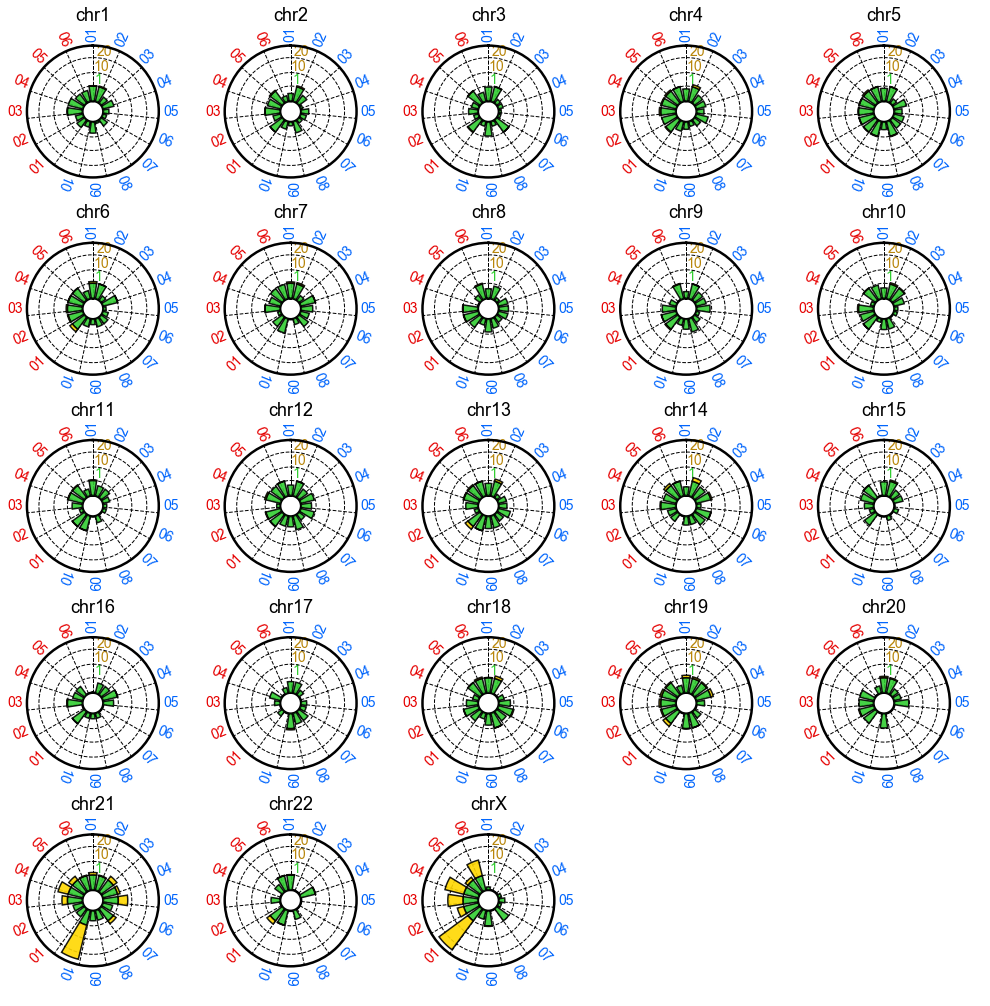

In [36]:
a4f = 2.5
width_a4f = 0.8
hight_a4f = 0.6

fig, axs = plt.subplots( 
    ncols=5, nrows=5, 
    figsize=(a4f*width_a4f*8.27,a4f*hight_a4f*11.69),
    subplot_kw=dict(projection='polar'), 
    gridspec_kw={'hspace':0.2, 'wspace':0.5},
)

axs = axs.flatten()
for n,chrom in enumerate(ref['space'].unique()[:-1]):
    radar_plot(axs[n],chrom, FSAMPLE=FSAMPLE)

axs[-2].axis('off')
axs[-1].axis('off')

fig.savefig('A4_SI_Radar.pdf', frameon=False, transparent=True, bbox_inches='tight')
plt.show()

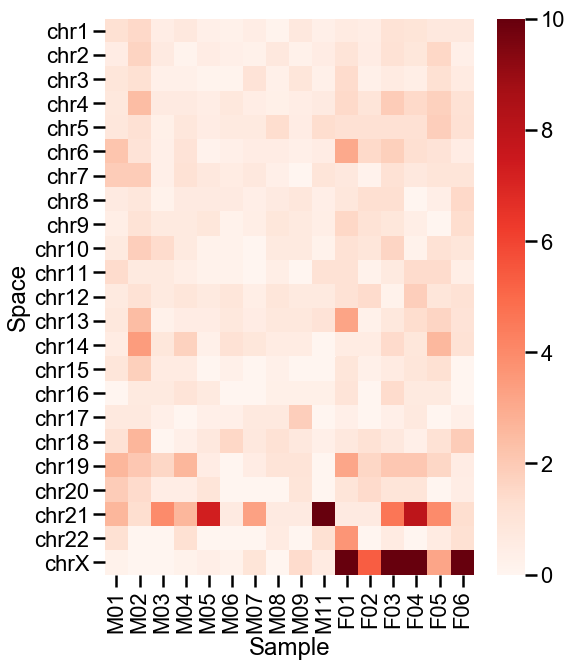

In [37]:
chrlen = (100*ref.groupby('space')['end'].max()/ref.groupby('space')['end'].max().sum())
cnv_chr_counts['norm_Cell'] = (cnv_chr_counts.set_index('Space')['Cell']/chrlen).dropna().values

df = cnv_chr_counts.pivot(index='Space',columns='Sample', values='norm_Cell').fillna(0).loc[
    ref['space'].unique(),
    xlsx_tab['SAMPLE'],
].drop('$FSAMPLE',axis=1).drop('chrY')


a4f = 2.5
width_a4f = 0.4
hight_a4f = 0.35

fig, ax = plt.subplots( 
    figsize=(a4f*width_a4f*8.27,a4f*hight_a4f*11.69),
)

sns.heatmap(df, vmax=10, cmap='Reds', ax=ax)

ax.set_xticklabels( xlsx_tab.set_index('SAMPLE').drop('$FSAMPLE')['CODE'] )

plt.show()

---

In [39]:
bin_bed  = BedTools.from_dataframe(ref.loc[good_pos])

cnv_bed = (
    sum_df
    .loc[big_cnv_idx]
#     .query('chrom_fraction<95')
    .groupby(['Cell','Space']).first().reset_index()
    .loc[:,['Chromosome','Start','End']]
)

# cnv_bed['End'] = cnv_bed['Start'].astype(int)+1
cnv_bed = BedTools.from_dataframe(cnv_bed)

out_bed = (
    sum_df
    .loc[big_cnv_idx]
#     .query('Space!="chrX" & Space!="chr21"')
#     .query('chrom_fraction<95')
    .groupby(['Cell','Space']).first().reset_index()
    .loc[:,['Chromosome','Start','End']]
)
# out_bed['End'] = out_bed['Start'].astype(int)+1
out_bed = BedTools.from_dataframe(out_bed)

bad_bed = BedTools.from_dataframe(ref.drop(good_pos))

# shf_bed = BedTools.shuffle(cnv_bed, genome='hg38')
# shf_bed = BedTools.shuffle(out_bed, genome='hg38', maxTries=30000)
# shf_bed = BedTools.shuffle(out_bed, genome='hg38', chrom=True, maxTries=10000)

bin_ratio = (
    100
    *
    BedTools.intersect(self=bin_bed,b=cnv_bed,wa=True,c=True).to_dataframe().set_index(good_pos)['score']
    /
    cells_tab.loc[xlsx_tab.set_index('SAMPLE').drop('$FSAMPLE').index, 'n_pf'].sum()
).loc[ ref.loc[good_pos].query('space!="chrY"').index ]

shf_bed = BedTools.shuffle(out_bed, genome='hg38', chrom=True, maxTries=10000, excl=bad_bed._tmp(), seed=0)

shf_ratio = (
    100
    *
    BedTools.intersect(self=bin_bed,b=shf_bed,wa=True,c=True).to_dataframe().set_index(good_pos)['score']
    /
    cells_tab.loc[xlsx_tab.set_index('SAMPLE').drop('$FSAMPLE').index, 'n_pf'].sum()
).loc[ ref.loc[good_pos].query('space!="chrY"').index ]

tmpCleanUp()


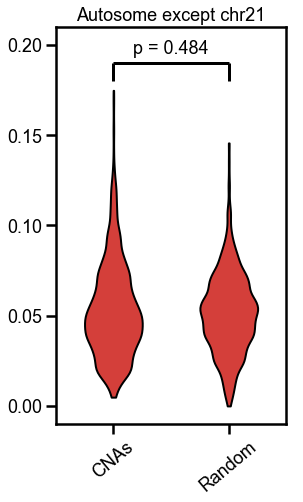

In [40]:

a4f = 2.5
width_a4f = 0.2
hight_a4f = 0.25

fig, ax = plt.subplots( 
    figsize=(a4f*width_a4f*8.27,a4f*hight_a4f*11.69),
)

a = bin_ratio[~(bin_ratio.index.str.contains('chr21') | bin_ratio.index.str.contains('chrX'))]
b = shf_ratio[~(shf_ratio.index.str.contains('chr21') | shf_ratio.index.str.contains('chrX'))]

c = bin_ratio[ (bin_ratio.index.str.contains('chr21')) ]
d = bin_ratio[ (bin_ratio.index.str.contains('chrX')) ]

parts1 = ax.violinplot(
    a, positions=[0],
    showmeans=False, showmedians=False,
        showextrema=False,
)
parts2 = ax.violinplot(
    b, positions=[1],
    showmeans=False, showmedians=False,
        showextrema=False,
)

for pc in [parts1['bodies'][0], parts2['bodies'][0]]:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)


ax.set_xticks([0,1])
ax.set_xticklabels(['CNAs', 'Random'], rotation=40, fontsize=midsize)

ax.set_yticks([0,0.05,0.1,0.15,0.2])

ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.01,0.21)
ax.set_title('Autosome except chr21', fontsize=midsize)

ax.tick_params(axis='x', length=10, labelsize=midsize)
ax.tick_params(axis='y', length=10, labelsize=midsize)

ax.hlines(0.19, 0, 1)
ax.vlines(0, 0.18, 0.19)
ax.vlines(1, 0.18, 0.19)

ax.text(0.5, 0.195, 'p = {:.3f}'.format(stats.mannwhitneyu(a,b).pvalue), ha='center', fontsize=midsize)

plt.show()


fig.savefig('A4_SI_random.pdf', frameon=False, transparent=True, bbox_inches='tight')


---

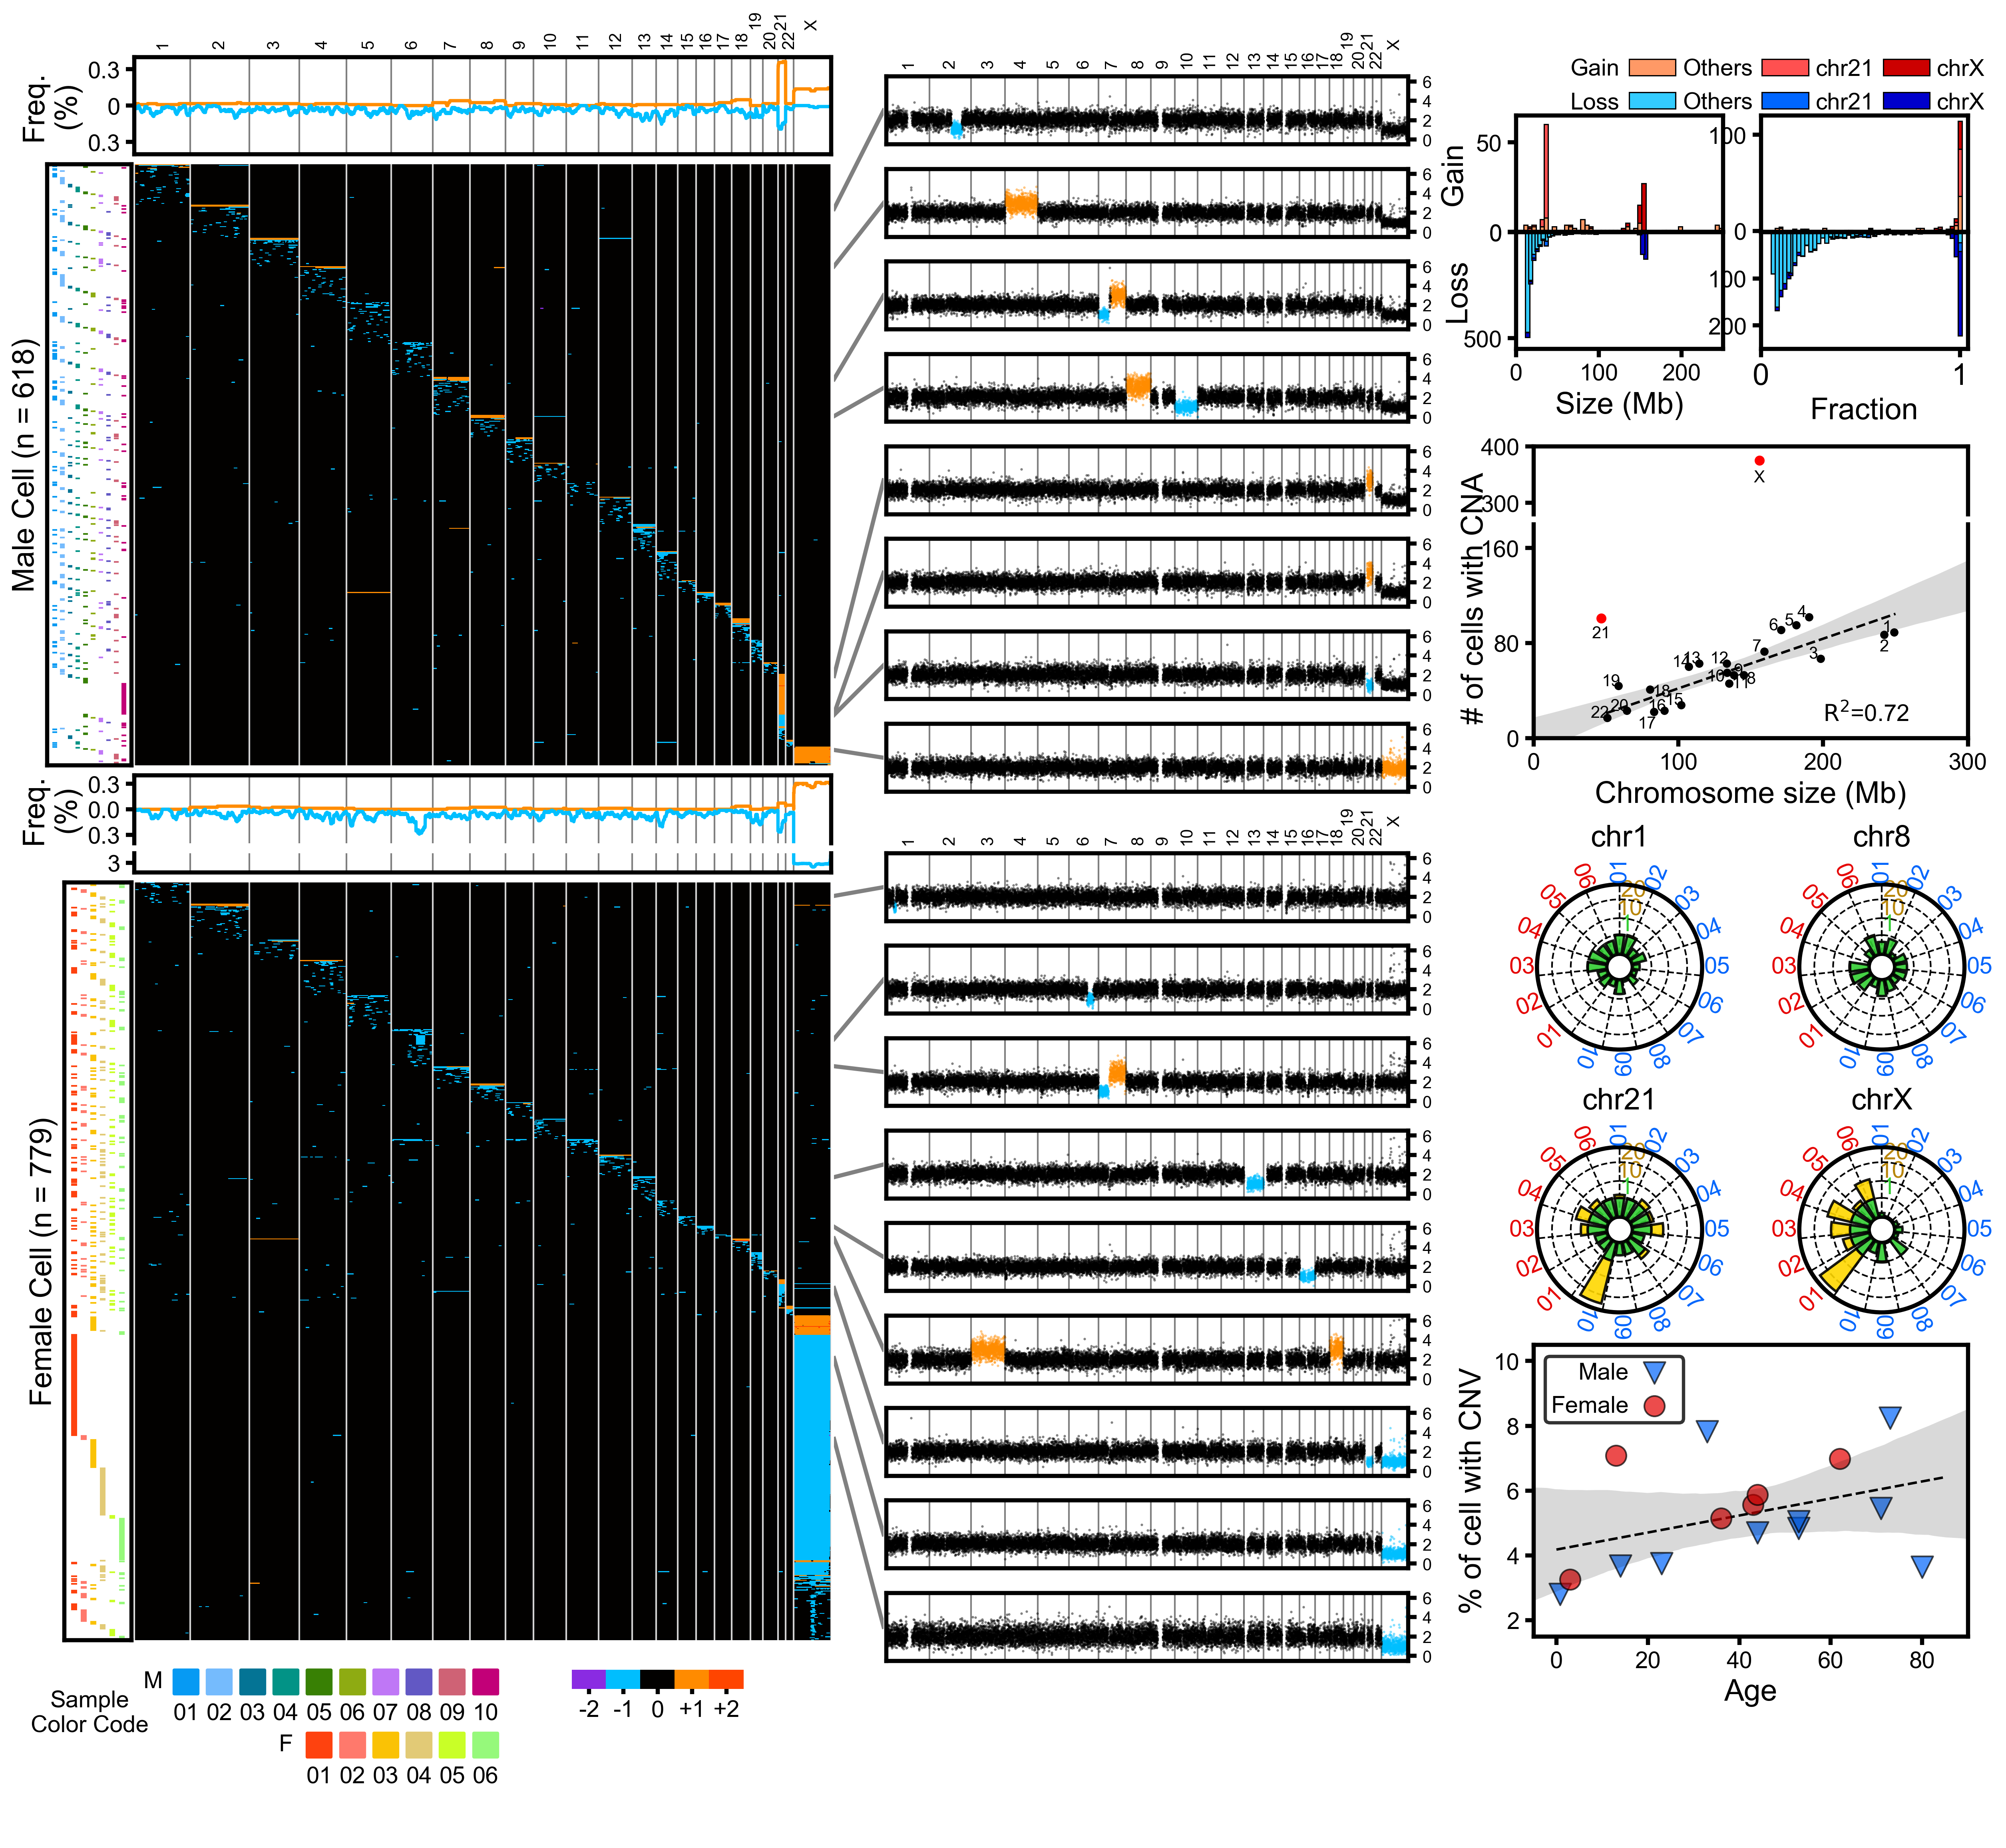

In [42]:
a4f = 2.5
width_a4f = 1
hight_a4f = 0.65

hs = 10  # space
hb = 20  # colorbar
hp = 100 # plot

h_total = 3*hp + 5*hs + male_fig_df.shape[0] + female_fig_df.shape[0] + hb

fig = plt.figure(figsize=(a4f*width_a4f*8.27,a4f*hight_a4f*11.69),dpi=300,)
gs  = mpl.gridspec.GridSpec(nrows=h_total, ncols=110, figure=fig)

h1 = hp

ax1 = fig.add_subplot( gs[     0:h1,  5:45 ] )

male_genome_plot(ax1, FSAMPLE=FSAMPLE)

h2 = h1 + hs + male_fig_df.shape[0]
ax2 = fig.add_subplot( gs[ h1+hs:h2,  0:5  ] )
ax3 = fig.add_subplot( gs[ h1+hs:h2,  5:45 ]) # sharey=ax2

male_heatmap_plot(ax2, ax3)

ax2.set_ylim(ax3.get_ylim())

h3 = h2 + hs + hp
bp = int(h3-hp/4)

ax4a = fig.add_subplot( gs[ h2+hs:bp-5,  5:45 ])
ax4b = fig.add_subplot( gs[    bp+5:h3,  5:45 ])

female_genome_plot(ax4a, ax4b)

ax1.set_xlim(ax3.get_xlim())
ax4a.set_xlim(ax1.get_xlim())
ax4b.set_xlim(ax1.get_xlim())

h4 = h3 + hs + female_fig_df.shape[0]
ax5 = fig.add_subplot( gs[ h3+hs:h4,  1:5  ] )
ax6 = fig.add_subplot( gs[ h3+hs:h4,  5:45 ]) # sharex=ax3, sharey=ax5

h5 = h4 + 3*hs + hb
ax7 = fig.add_subplot( gs[ h4+3*hs:h5,  30:40 ] )

female_heatmap_plot(ax5, ax6, ax7)

ax5.set_ylim(ax6.get_ylim())

ax7.tick_params(length=3, labelsize=smallsize)
ax7.set_xticklabels( ['-2','-1','0','+1','+2'] )

ax8 = fig.add_subplot( gs[ h4+hs:h5+hp, 7:30 ] )
sample_code_plot(ax8, FSAMPLE=FSAMPLE)

axl = fig.add_subplot( gs[  0:h_total, 45:48 ] )
axl.axis('off')
axl.set_xlim(0,1)
axl.set_ylim(h_total,0)

hc = 70
s = 20
l = 25

male_heatmap_idx = male_fig_df.reindex(index=heatmap_order).dropna().index
male_heatmap_n = []
for cell in male_cells:
    i = male_heatmap_idx.get_loc(cell)
    male_heatmap_n.append(h1+hs+i)

female_heatmap_idx = female_fig_df.reindex(index=heatmap_order).dropna().index
female_heatmap_n = []
for cell in female_cells:
    i = female_heatmap_idx.get_loc(cell)
    female_heatmap_n.append(h3+hs+i)

lax = None
for i in np.arange(len(male_cells)):
    axl.plot( [ 0, 1 ], [ male_heatmap_n[i], s+hc/2 ], color='grey', lw=2.5 )
    ax_c = fig.add_subplot( gs[  s:s+hc,   48:78 ] )
    showCell(male_cells[i], give_ax=[ax_c], alpha=0.5, ms=1)
    ax_c.tick_params(axis='y', labelsize=10, length=5)
    ax_c.set_ylabel('')
    if not lax:
        lax = ax_c
    s = s+hc+l

lax.set_xticks( ref.groupby('space',sort=False)['abs_pos'].min().rolling(2).mean()[1:] )
lax.set_xticklabels(
    ref['space'].drop_duplicates()[:-1].str.replace('chr','').replace('19','    19').replace('21','    21').replace('X','    X'), 
    fontsize=smallsize-4,
    ha='center',
    rotation=90,
)
lax.xaxis.set_ticks_position('top')
lax.tick_params(axis='x', bottom=False, length=0, pad=5)
    
s = h3 - 20

lax = None
for i in np.arange(len(female_cells)):
    axl.plot( [ 0, 1 ], [ female_heatmap_n[i], s+hc/2 ], color='grey', lw=2.5 )
    ax_c = fig.add_subplot( gs[  s:s+hc,   48:78 ] )
    showCell(female_cells[i], give_ax=[ax_c], alpha=0.5, ms=1)
    ax_c.tick_params(axis='y', labelsize=10)
    ax_c.set_ylabel('')
    if not lax:
        lax = ax_c
    s = s+hc+l

lax.set_xticks( ref.groupby('space',sort=False)['abs_pos'].min().rolling(2).mean()[1:] )
lax.set_xticklabels(
    ref['space'].drop_duplicates()[:-1].str.replace('chr','').replace('19','    19').replace('21','    21').replace('X','    X'), 
    fontsize=smallsize-4,
    ha='center',
    rotation=90,
)
lax.xaxis.set_ticks_position('top')
lax.tick_params(axis='x', bottom=False, length=0, pad=5)

ax_size1   = fig.add_subplot( gs[   60:180,  84:96 ] )
ax_size2   = fig.add_subplot( gs[  180:300,  84:96 ] )

ax_size3   = fig.add_subplot( gs[   60:180, 98:110 ] )
ax_size4   = fig.add_subplot( gs[  180:300, 98:110 ] )

# ax_chrsize = fig.add_subplot( gs[  400:700,  85:   ] )
ax_chrsize1 = fig.add_subplot( gs[  400:470,  85:   ] )
ax_chrsize2 = fig.add_subplot( gs[  480:700,  85:   ] )
ax_chrsize = (ax_chrsize1, ax_chrsize2)

ax_age     = fig.add_subplot( gs[  s-350:s-50,  85:   ] )

size_plot(ax_size1, ax_size2, ax_size3, ax_size4)

axl_size   = fig.add_subplot( gs[     0:60,  85: ] )

h1s,l1s = ax_size1.get_legend_handles_labels()
h2s,l2s = ax_size3.get_legend_handles_labels()
h3s,l3s = ax_size2.get_legend_handles_labels()
h4s,l4s = ax_size4.get_legend_handles_labels()

handles = h1s + h2s + h3s + h4s
labels  = l1s + l2s + l3s + l4s

labels  = np.array(labels).reshape(2,4).T.flatten()
handles = np.array(handles).reshape(2,4).T.flatten()

axl_size.axis('off')
axl_size.legend(
    handles, labels,
    loc='center',
    prop={'size':smallsize},
    ncol=4,
    columnspacing=0.4, handletextpad=0.3,
    frameon=False
)

chr_size_plot(ax_chrsize, FSAMPLE=FSAMPLE)

age_plot(ax_age)

ax_radar1 = fig.add_subplot( gs[   850:1020,  85:95  ], polar=True )
ax_radar2 = fig.add_subplot( gs[   850:1020, 100:    ], polar=True )
ax_radar3 = fig.add_subplot( gs[  1120:1290,  85:95  ], polar=True )
ax_radar4 = fig.add_subplot( gs[  1120:1290, 100:    ], polar=True )

radar_plot(ax_radar1, 'chr1',  FSAMPLE=FSAMPLE)
radar_plot(ax_radar2, 'chr8',  FSAMPLE=FSAMPLE)
radar_plot(ax_radar3, 'chr21', FSAMPLE=FSAMPLE)
radar_plot(ax_radar4, 'chrX',  FSAMPLE=FSAMPLE)

# fig.savefig('A4_fig2.pdf', frameon=False, transparent=True, bbox_inches='tight')
fig.savefig('A4_fig2.svg', frameon=False, transparent=True, bbox_inches='tight')
# fig.savefig('A4_fig2.jpg', frameon=False, transparent=True, bbox_inches='tight')

---